In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_GiuaKy'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_GiuaKy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('dataset_2190_cholesterol.csv', na_values='?')
data.head()

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,chol
0,63,1,1,145,1,2,150,0,2.3,3,0.0,6.0,0,233
1,67,1,4,160,0,2,108,1,1.5,2,3.0,3.0,2,286
2,67,1,4,120,0,2,129,1,2.6,2,2.0,7.0,1,229
3,37,1,3,130,0,0,187,0,3.5,3,0.0,3.0,0,250
4,41,0,2,130,0,2,172,0,1.4,1,0.0,3.0,0,204


**Phân tích:**
- Trong thực tế y khoa, kết quả đo chol chỉ là để chỉ ra được cholesterol **bình thường **(<200mg/dl), **cao giới hạn** (200-239mg/dl) hay **cao** (>=240mg/dl). (nguồn: http://viendinhduong.vn/vi/dinh-duong-tiet-che/nhung-dieu-can-biet-ve-cholesterol-mau.html)
- Ví dụ: nếu chỉ số chol 180mg/dl mà model predict ra 195mg/dl hay 170mg/dl thì đều thuộc nhóm bình thường (<200mg/dl), nên việc thực hiện Regression để chỉ ra chính xác bao nhiêu mg/dl là **không quan trọng bằng việc xác định mức chol ở nhóm nào trong 3 nhóm kể trên**, để từ đó đưa ra các kết luận về bệnh lý có liên quan.
- Vậy nên thay về thực hiện Regression, ta sẽ chia lại chỉ số chol vào 3 nhóm trên và tiến hành xây dựng model về **Classification**.

In [ ]:
print('Chol min: {}, max {}'.format(data['chol'].min(), data['chol'].max()))

Chol min: 126, max 564


In [ ]:
bins = [0, 200, 240, 600]
labels = ['Normal', 'High', 'Very High']
classes = [0, 1, 2]
data['chol'] = pd.cut(data['chol'], right=False, bins=bins, labels=classes)
data.head()

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,chol
0,63,1,1,145,1,2,150,0,2.3,3,0.0,6.0,0,1
1,67,1,4,160,0,2,108,1,1.5,2,3.0,3.0,2,2
2,67,1,4,120,0,2,129,1,2.6,2,2.0,7.0,1,1
3,37,1,3,130,0,0,187,0,3.5,3,0.0,3.0,0,2
4,41,0,2,130,0,2,172,0,1.4,1,0.0,3.0,0,1


Kiểm tra xem data chol đã convert có phân phối ra sao.

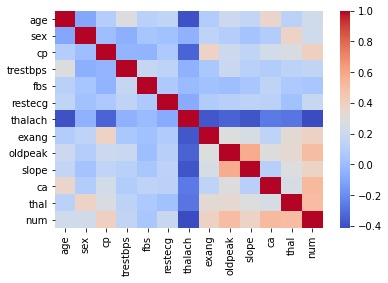

In [ ]:
sb.heatmap(data.corr(), cmap='coolwarm')

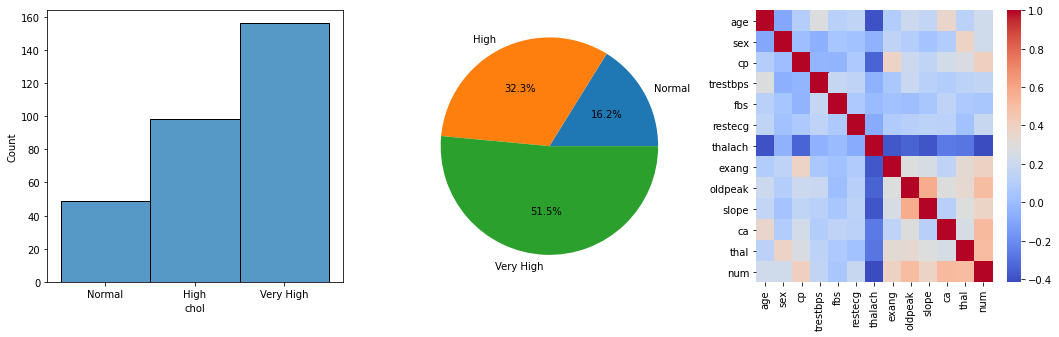

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sb.histplot(data['chol'])
plt.xticks([0, 1, 2], labels)

plt.subplot(1,3,2)
plt.pie(data['chol'].value_counts().sort_index(), labels=labels, autopct='%1.1f%%')

plt.subplot(1,3,3)
sb.heatmap(data.corr(), cmap='coolwarm')
plt.show()

Nhận xét:
- Phân phối biến target có sự mất cân bằng (imbalanced), trọng số các mẫu đang nghiên về nhóm 'Very High', vậy nên cần có để ý khi phân tích kết quả.
- Test Accuracy của model phải trên 52% thì model mới được xem là có giá trị dự đoán.
- Có thể sử dụng các kỹ thuật over_sampling hay under_sampling để balanced lại dữ liệu, tuy nhiên việc này chỉ để model đạt được kết quả dự đoán có precission và recall không thiên lệch về 1 nhóm tỷ trọng lớn trong target, chứ không mang tính chất tăng cường độ chính xác (accuracy) cho mô hình. Đôi khi có thể giảm độ chính xác vì để tăng precission và recall cho nhóm tỷ trọng thấp khó dự đoán hơn. 
- Mối hiện hệ giữa nhóm chol và các biến khác vẫn rất thấp, đây vẫn là nhân tố quyết định độ chính xác mô hình tạo ra từ input -> output.
- Về data set, như đã phân tích ở Part 1 (Regression), có đến 9 biến input categorical đều đã được convert sang numerical. Nên khi đưa vào làm input cho một vài model cần phải convert sang one-hot encoding, một vài model có thể không cần như hệ model Tree: Random Forest, Boosting...

Các model có thể sử dụng cho Classification:
- **Logistic Regression:** thường cần phần lựa chọn biến X cho phù hợp
- **KNN:** lựa chọn k phù hợp
- **Naive Bayes:** dựa trên lý thuyết xác suất Bayes
- **Decision Tree, Random Forest:** lựa chọn Random Forest vì thường cho kết quả tốt hơn Decision Tree 1 cây đơn lẻ
- **SVM:** sử dụng SVC
- **AdaBoost:** sử dụng với base estimator Random Forest
- **XGBoost:** cũng là 1 powerfull technique như AdaBoost

Về cách evaluation model:
- Vì đây là data set nhỏ và chỉ bao gồm 1 data, không tách biệt ngay từ ban đầu train-test set, nên có 2 cách để evaluate model:
    - **Cách 1:** Chia data thành **train-test set**, tiến hành train model trên **train data**, tunning hyper-parameter bằng Cross-validation hay Grid trên **train data**, chọn model có test-cross_validation accuracy tốt nhất. Sau đó đem model test kết quả trên **test data**, để xem model có thể dự đoán tốt trên dữ liệu chưa từng thấy hay không.
    - **Cách 2:** **Không chia data thành train-test set** vì số lượng mẫu khá nhỏ, chạy **cross-validation xem kết quả trên full X, y**, đồng thời tunning hyper-parameter bằng cross-validation, sau đó chọn model có test-cross_validation accuracy tốt nhất. Với model tìm được, hi vọng model vẫn có thể dự đoán tốt trên dữ liệu chưa từng thấy trong tương lai.
- Ở bài toán này, ta xây dựng cách evaluation theo **Cách 1**.

Các bước sẽ thực hiện xây dựng models:
- Dùng lại các function đã viết ở Regression, tạo các data cho phù hợp.
- Tổng hợp các models đã liệt kê bên trên vào 1 list, hyper-parameter để default.
- Viết function chạy Cross-validation list models, xem kết quả ban đầu các models nào có hiệu quả cao, models nào hiệu quả thấp.
- Chọn ra các models hiệu quả và tiến hành tuning hyper-parameters bằng Grid.
- Chạy lại kết quả list_models_best đã tuning, xem hiệu quả có được cải thiện, chọn ra model có test-cv tốt nhất.
- Chạy kết quả cuối cùng trên test set, xem kết quả có khác biệt gì nhiều so với test-cv trước đây.

In [ ]:
# Sử dụng KNNImputer để filling missing values.
from sklearn.impute import KNNImputer
imputer = KNNImputer()
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
numeric = ['age', 'trestbps', 'thalach', 'oldpeak']
categoric = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']

In [ ]:
# Viết function pre-processing
def pre_processing(data, scaler, numeric_col=numeric, categoric_col=categoric, target_col=['chol'], one_hot=False):
    df_num = data[numeric_col]
    # One-hot
    if one_hot:
        df_cate = pd.get_dummies(data[categoric_col], columns=categoric_col, drop_first=True)
    else:
        df_cate = data[categoric_col]

    df_target = data[target_col]
    df = pd.concat([df_num, df_cate, df_target], axis=1)

    # Split train-test
    from sklearn.model_selection import train_test_split
    X = df.drop(columns=['chol'])
    y = df['chol']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    # Sử dụng Robust Scaler
    X_train[numeric] = scaler.fit_transform(X_train[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])

    return X_train, X_test, y_train, y_test

# Viết function SelectKbest để chọn các biến có tương quan tốt nhất tiến hành Features Selection.
def select_k_best_features(data, scaler, one_hot, threshold=1.0):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_classif
    X_train, X_test, y_train, y_test = pre_processing(data=data, scaler=scaler, one_hot=one_hot)

    best_k_features = SelectKBest(score_func=f_classif, k='all')
    best_k_features.fit(X_train, y_train)
    score = pd.Series(best_k_features.scores_)
    col = pd.Series(X_train.columns)
    result = pd.DataFrame({'Features': col, 'Score': score}).sort_values(by='Score', ascending=False)

    result = result[result['Score'] > threshold]
    print('SelectKBest - one_hot={}'.format(one_hot))
    display(result)
    features = result['Features'].to_list()
    return X_train[features], X_test[features], y_train, y_test

# Viết function FeatureImportance của Random Forest để chọn các biến có tương quan tốt nhất tiến hành Features Selection.
def feature_importance_rdn_forest(data, scaler, one_hot, threshold=0.02):
    from sklearn.ensemble import RandomForestClassifier
    X_train, X_test, y_train, y_test = pre_processing(data=data, scaler=scaler, one_hot=one_hot)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    score = pd.Series(model.feature_importances_)
    col = pd.Series(X_train.columns)
    result = pd.DataFrame({'Features': col, 'Score': score}).sort_values(by='Score', ascending=False)

    result = result[result['Score'] > threshold]
    print('FeaturesImportance by Random Forest - one_hot={}'.format(one_hot))
    display(result)
    features = result['Features'].to_list()
    return X_train[features], X_test[features], y_train, y_test

# Viết function sử dụng PCA, convert data thành các Principal Component, lựa chọn số lượng PC cho phù hợp để tạo data mới cho model
def pca_k_selection(data, scaler, one_hot, threshold=0.9):
    from sklearn.decomposition import PCA
    X_train, X_test, y_train, y_test = pre_processing(data=data, scaler=scaler, one_hot=one_hot)

    pca_n = PCA()
    P = pd.DataFrame(pca_n.fit_transform(X_train))
    result_pca = pd.DataFrame({'Dimension': np.arange(1,pca_n.n_components_ + 1),'Cum_ratio': np.cumsum(pca_n.explained_variance_ratio_)})
    result_pca = result_pca[result_pca['Cum_ratio'] <= threshold]
    print('PCA features selection - one_hot={}'.format(one_hot))
    display(result_pca)
    
    k = result_pca.iloc[-1, 0]
    pca = PCA(k)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=['PC_'+str(i) for i in range(1,k+1)])
    X_test = pd.DataFrame(X_test, columns=['PC_'+str(i) for i in range(1,k+1)])

    return X_train, X_test, y_train, y_test

# Viết function sử dụng over_sampling
def over_sampling(data):
    from imblearn.over_sampling import SMOTE

    X_train, X_test, y_train, y_test = data
    oversampling = SMOTE()
    X_train, y_train = oversampling.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# 2 data_set không qua lựa chọn biến
data_set_1 = pre_processing(data, scaler, one_hot=False)
data_set_2 = pre_processing(data, scaler, one_hot=True)

# 2 data_set có lựa chọn biến bằng SelectKbest
data_set_3 = select_k_best_features(data, scaler, one_hot=False, threshold=0.5)
data_set_4 = select_k_best_features(data, scaler, one_hot=True, threshold=1)

# 2 data_set có lựa chọn biến bằng SelectKbest
data_set_5 = feature_importance_rdn_forest(data, scaler, one_hot=False, threshold=0.05)
data_set_6 = feature_importance_rdn_forest(data, scaler, one_hot=True, threshold=0.05)

# 2 data_set convert qua PCA
data_set_7 = pca_k_selection(data, scaler, one_hot=False, threshold=0.9)
data_set_8 = pca_k_selection(data, scaler, one_hot=True, threshold=0.9)

# Tạo list data-set:
list_data_set = [
            ('data full', data_set_1),
            ('data full - one_hot', data_set_2),
            ('data SelectKbest', data_set_3),
            ('data SelectKbest - one_hot', data_set_4),
            ('data rdn_forest', data_set_5),
            ('data rdn_forest - one_hot', data_set_6),
            ('data pca', data_set_7),
            ('data pca - one_hot', data_set_8),
]

SelectKBest - one_hot=False


,Features,Score
7,restecg,5.237717
0,age,2.987682
4,sex,2.703838
8,exang,2.318516
2,thalach,1.808778
1,trestbps,1.756772
9,slope,1.221844
5,cp,0.854763


SelectKBest - one_hot=True


,Features,Score
10,restecg_2.0,5.233664
13,slope_3.0,3.392672
0,age,2.987682
4,sex_1.0,2.703838
11,exang_1.0,2.318516
2,thalach,1.808778
1,trestbps,1.756772
21,thal_6.0,1.449113
17,ca_2.0,1.132930
19,thal_3.8,1.077124


FeaturesImportance by Random Forest - one_hot=False


,Features,Score
2,thalach,0.186461
0,age,0.165483
1,trestbps,0.152847
3,oldpeak,0.124932
5,cp,0.057724
12,num,0.052264


FeaturesImportance by Random Forest - one_hot=True


,Features,Score
2,thalach,0.170418
0,age,0.164962
1,trestbps,0.131254
3,oldpeak,0.119806


PCA features selection - one_hot=False


,Dimension,Cum_ratio
0,1,0.443699
1,2,0.580365
2,3,0.668039
3,4,0.741462
4,5,0.803594
5,6,0.854458
6,7,0.897112


PCA features selection - one_hot=True


,Dimension,Cum_ratio
0,1,0.241799
1,2,0.388489
2,3,0.476813
3,4,0.549119
4,5,0.606810
5,6,0.658915
6,7,0.706264
7,8,0.744402
8,9,0.780139
9,10,0.814975


In [ ]:
# Tạo data sử dụng over_sampling SMOTE
data_set_1_smote = over_sampling(data_set_1)
data_set_2_smote = over_sampling(data_set_2)
data_set_3_smote = over_sampling(data_set_3)
data_set_4_smote = over_sampling(data_set_4)
data_set_5_smote = over_sampling(data_set_5)
data_set_6_smote = over_sampling(data_set_6)
data_set_7_smote = over_sampling(data_set_7)
data_set_8_smote = over_sampling(data_set_8)

# Tạo list data-set:
list_data_set_smote = [
            ('data full_smote', data_set_1_smote),
            ('data full - one_hot_smote', data_set_2_smote),
            ('data SelectKbest_smote', data_set_3_smote),
            ('data SelectKbest - one_hot_smote', data_set_4_smote),
            ('data rdn_forest_smote', data_set_5_smote),
            ('data rdn_forest - one_hot_smote', data_set_6_smote),
            ('data pca_smote', data_set_7_smote),
            ('data pca - one_hot_smote', data_set_8_smote),
]

In [ ]:
# Tổng hợp các models đã liệt kê bên trên vào 1 list, hyper-parameter để default.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold

# Vì SVM poly được xem là model mạnh mẽ hơn Polynorminal thông thường, nên ở đây ta chỉ cần sử dụng SVM poly
list_model = [
              ('Linear Regression', LogisticRegression()),
              ('Naive Bayes', GaussianNB()),
            #   ('KNN (3)', KNeighborsClassifier(3)),
              ('KNN (5)', KNeighborsClassifier(5)),
            #   ('KNN (8)', KNeighborsClassifier(8)),
              ('SVC - linear', SVC(kernel='linear')),
              ('SVC - poly 2', SVC(kernel='poly', degree=2)),
            #   ('SVC - poly 3', SVC(kernel='poly', degree=3)),
              ('SVC - rbf', SVC(kernel='rbf')),
              ('Random Forest', RandomForestClassifier(random_state=42)),
            #   ('AdaBoost', AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=42), random_state=42)),
            #   ('XGBoost', XGBRegressor()),
]

In [ ]:
# Viết function chạy Cross-validation 5-folds cho list models, xem kết quả ban đầu các models nào có hiệu quả cao, models nào hiệu quả thấp.
def result_model_cv(list_model, data_set, cv_k=5, show_table=False):
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import cross_validate, KFold
    from sklearn.metrics import accuracy_score, f1_score

    data_name, data = data_set
    X_train, X_test, y_train, y_test = data

    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)
    result = []
    for name, model in list_model:
        cv_result = cross_validate(model, X_train, y_train, cv=kfold, return_train_score=True, scoring=['accuracy', 'f1_micro'])
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        result.append([data_name, name, 
                       cv_result['train_accuracy'].mean(),
                       cv_result['test_accuracy'].mean(),
                       cv_result['train_f1_micro'].mean(),
                       cv_result['test_f1_micro'].mean(),
                       cv_result['fit_time'].mean(),
                       cv_result['score_time'].mean(),
                       accuracy_score(y_train, y_pred_train),
                       accuracy_score(y_test, y_pred_test),
                       f1_score(y_train, y_pred_train, average='micro'),
                       f1_score(y_test, y_pred_test, average='micro'),
        ])

    result = pd.DataFrame(result, columns=['data_set', 'model', 'train_cv_accuracy', 'test_cv_accuracy',  
                                           'train_cv_f1', 'test_cv_f1', 'fit_time', 'score_time',
                                           'train_accuracy', 'test_accuracy', 'train_f1', 'test_f1',
                                           ])
    result.sort_values('test_cv_f1', ascending=True, inplace=True)
    if show_table:
        display(result)
    return result

**Note:** 
- Vì mục đích viết function này là để xem cross-validation result, và lựa chọn model trên CV. 
- Tuy nhiên em viết thêm để xem luôn kết quả trên test-set cho sau này dễ theo dõi. hihi

In [ ]:
list_result = []
for data_set in list_data_set:
    list_result.append(result_model_cv(list_model, data_set, cv_k=5))
result = pd.concat(list_result, axis=0)
display(result.sort_values(['model', 'test_f1'], ascending=[True, False]))

,data_set,model,train_cv_accuracy,test_cv_accuracy,train_cv_f1,test_cv_f1,fit_time,score_time,train_accuracy,test_accuracy,train_f1,test_f1
2,data rdn_forest - one_hot,KNN (5),0.601324,0.365990,0.601324,0.365990,0.001730,0.004576,0.621145,0.500000,0.621145,0.500000
2,data pca,KNN (5),0.631030,0.497681,0.631030,0.497681,0.001700,0.004066,0.621145,0.460526,0.621145,0.460526
2,data SelectKbest - one_hot,KNN (5),0.635499,0.494010,0.635499,0.494010,0.002108,0.004607,0.638767,0.434211,0.638767,0.434211
2,data SelectKbest,KNN (5),0.643167,0.471498,0.643167,0.471498,0.002195,0.004573,0.616740,0.421053,0.616740,0.421053
2,data full - one_hot,KNN (5),0.632135,0.418357,0.632135,0.418357,0.002241,0.005036,0.638767,0.407895,0.638767,0.407895
2,data rdn_forest,KNN (5),0.609010,0.374493,0.609010,0.374493,0.001983,0.004803,0.612335,0.407895,0.612335,0.407895
2,data full,KNN (5),0.630982,0.493333,0.630982,0.493333,0.001833,0.004284,0.638767,0.394737,0.638767,0.394737
2,data pca - one_hot,KNN (5),0.629913,0.427150,0.629913,0.427150,0.002024,0.004468,0.634361,0.368421,0.634361,0.368421
0,data rdn_forest,Linear Regression,0.538553,0.520097,0.538553,0.520097,0.012822,0.002000,0.533040,0.486842,0.533040,0.486842
0,data rdn_forest - one_hot,Linear Regression,0.528620,0.507053,0.528620,0.507053,0.006639,0.002146,0.524229,0.486842,0.524229,0.486842


In [ ]:
list_result = []
for data_set in list_data_set_smote:
    list_result.append(result_model_cv(list_model, data_set, cv_k=5))
result = pd.concat(list_result, axis=0)
display(result.sort_values(['model', 'test_f1'], ascending=[True, False]))

,data_set,model,train_cv_accuracy,test_cv_accuracy,train_cv_f1,test_cv_f1,fit_time,score_time,train_accuracy,test_accuracy,train_f1,test_f1
2,data SelectKbest_smote,KNN (5),0.706928,0.576177,0.706928,0.576177,0.000662,0.004456,0.725989,0.394737,0.725989,0.394737
2,data pca_smote,KNN (5),0.704081,0.556298,0.704081,0.556298,0.000757,0.004663,0.725989,0.355263,0.725989,0.355263
2,data SelectKbest - one_hot_smote,KNN (5),0.732360,0.548169,0.732360,0.548169,0.000734,0.004625,0.748588,0.342105,0.748588,0.342105
2,data pca - one_hot_smote,KNN (5),0.701272,0.561851,0.701272,0.561851,0.000758,0.004546,0.714689,0.342105,0.714689,0.342105
2,data full - one_hot_smote,KNN (5),0.699848,0.536620,0.699848,0.536620,0.000993,0.005307,0.706215,0.328947,0.706215,0.328947
2,data full_smote,KNN (5),0.693483,0.553602,0.693483,0.553602,0.000747,0.004536,0.697740,0.315789,0.697740,0.315789
2,data rdn_forest - one_hot_smote,KNN (5),0.697029,0.474527,0.697029,0.474527,0.000620,0.004137,0.723164,0.315789,0.723164,0.315789
2,data rdn_forest_smote,KNN (5),0.687849,0.519517,0.687849,0.519517,0.000642,0.004359,0.680791,0.263158,0.680791,0.263158
0,data pca_smote,Linear Regression,0.455497,0.398149,0.455497,0.398149,0.005830,0.001147,0.440678,0.407895,0.440678,0.407895
0,data rdn_forest - one_hot_smote,Linear Regression,0.449858,0.420724,0.449858,0.420724,0.004807,0.001080,0.477401,0.355263,0.477401,0.355263


Nhận xét:
- Kết quả cho thấy accuracy và f1-score trên test set hầu như chỉ trong khoảng 50%, không có model nào là vượt trội so với các model khác.
- Đồng thời so sánh kết quả model giữa các data set (không có SMOTE) khác nhau cũng không mang lại nhiều sự khác biệt.
- Trong trường hợp data set sử dụng oversampling, kết quả trên cross validation test accuracy có cải thiện (Random Forest được 68%, KNN được 60%). Tuy nhiên đây là kết quả không thật sự chính xác.
- Nếu thực hiện việc over_sampling để tính cross-validation test accuracy, cần làm như sau:
    - Dùng KFold chia ra các folds cho CV trên Train data.
    - Với mỗi bộ (vòng lặp) tập train-test cho từng lần CV (chia ở trên, chia từ tập Train), ta thực hiện:
        - Sử dụng SMOTE cân bằng cho train-set
        - Train model trên train-set
        - Tính accuracy trên test-set (test-set không có SMOTE)
        - Lưu kết quả, để sau này lấy trung bình.
- Trong khi theo cách làm ở trên là mình SMOTE cho cả bộ train lớn trong data, rồi sử dụng CV trên train data đó, (train trên SMOTE data, test trên SMOTE data trong mỗi lần CV). Nên kết quả ra so với test trên test set không có SMOTE khá là khác biệt.
- Tuy nhiên khi xem kết quả trên test data (cái này hơi cheating, hihi) thì test accuracy trên test data không những tăng mà còn giảm. Điều này cho thấy SMOTE không làm tăng độ chính xác cho các model, nó chỉ có tác dụng cân bằng precision-recall cho các target tỷ trọng nhỏ.
- Thử fine-tuning các model bằng Grid xem kết quả có được cải thiện không, sử dụng data full bình thường, không có one-hot.

In [ ]:
model_tunning_list = [
              ('SVC - linear', SVC(kernel='linear', random_state=42)),
              ('SVC - poly', SVC(kernel='poly', degree=2, random_state=42)),
              ('SVC - rbf', SVC(kernel='rbf', random_state=42)),
              ('Random Forest', RandomForestClassifier(random_state=42)),
              ('AdaBoost', AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=42), random_state=42)),
              ('KNN', KNeighborsClassifier()),
]
param_grid_svc_linear = {'C': [1, 10, 50, 100, 500],
            }

param_grid_svc_poly2 = {'C': [1, 10, 50, 100, 500],
              'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
            }

param_grid_svc_rbf = {'C': [1, 10, 50, 100, 500],
              'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
            }

param_grid_rdn_forest = {'n_estimators': [50, 100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'max_features': [2, 4, 5, 'sqrt', 'log2'],
            }

param_grid_ada_boost = {'n_estimators': [20, 30, 50, 100],
              'learning_rate': [0.001, 0.005, 0.01, 0.1],
            }

param_grid_knn = {'n_neighbors': [2, 3, 4, 5, 6, 7],
              'weights': ['uniform', 'distance'],
            }


params = [param_grid_svc_linear,
          param_grid_svc_poly2,
          param_grid_svc_rbf,
          param_grid_rdn_forest,
          param_grid_ada_boost,
          param_grid_knn,
]

In [ ]:
# Viết function tuning hyper-parameters models bằng Grid
def rename_keys(dic, pattern):
    return dict([(keys.split(pattern)[1], values) for keys, values in dic.items()])

def process_tunning_model(model_tunning_list, params, X, y, scoring='accuracy', cv_k=5):
    from sklearn.model_selection import GridSearchCV, KFold
    import time
    models_final = []
    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)

    for model_list, param in zip(model_tunning_list, params):
        tic = time.time()
        model_name, model = model_list
        search = GridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring=scoring)
        search.fit(X, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} have been tunned in {:,.2f} seconds'.format(model_name, (toc-tic)))
    return models_final

In [ ]:
X_train, X_test, y_train, y_test = data_set_1
models_final = process_tunning_model(model_tunning_list, params, X_train, y_train)
models_final

Model SVC - linear have been tunned in 51.21 seconds
Model SVC - poly have been tunned in 4.39 seconds
Model SVC - rbf have been tunned in 1.08 seconds
Model Random Forest have been tunned in 54.50 seconds
Model AdaBoost have been tunned in 14.03 seconds
Model KNN have been tunned in 0.29 seconds


[('SVC - linear',
  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
      max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
      verbose=False)),
 ('SVC - poly',
  SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=2, gamma=0.01, kernel='poly',
      max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
      verbose=False)),
 ('SVC - rbf',
  SVC(C=500, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
      max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
      verbose=False)),
 ('Random Forest',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='sqrt',
       

In [ ]:
result_model_cv(models_final, list_data_set[0])

,data_set,model,train_cv_accuracy,test_cv_accuracy,train_cv_f1,test_cv_f1,fit_time,score_time,train_accuracy,test_accuracy,train_f1,test_f1
4,data full,AdaBoost,1.000000,0.498261,1.000000,0.498261,0.160521,0.011148,1.000000,0.434211,1.000000,0.434211
3,data full,Random Forest,1.000000,0.507246,1.000000,0.507246,0.456295,0.043643,1.000000,0.434211,1.000000,0.434211
5,data full,KNN,1.000000,0.515072,1.000000,0.515072,0.001735,0.002751,1.000000,0.421053,1.000000,0.421053
1,data full,SVC - poly,0.599138,0.524541,0.599138,0.524541,0.004322,0.002090,0.590308,0.460526,0.590308,0.460526
2,data full,SVC - rbf,0.602416,0.533333,0.602416,0.533333,0.008007,0.002386,0.590308,0.460526,0.590308,0.460526
0,data full,SVC - linear,0.583693,0.542222,0.583693,0.542222,0.004806,0.002822,0.577093,0.447368,0.577093,0.447368


- Kết quả dường như không cải thiện được gì.
- Thử sử dụng Voting Classifier, là tập hợp lại các models_final đã được fine-tuning, sau đó bằng Voting algoritms để mỗi lần prediction lựa chọn kết quả của model nào là tốt nhất, từ đó gia tăng accuracy.

In [ ]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=models_final)
X_train, X_test, y_train, y_test = data_set_1
model.fit(X_train, y_train)
print('Accuracy Train: {:.4f}'.format(model.score(X_train, y_train)))
print('Accuracy Test: {:.4f}'.format(model.score(X_test, y_test)))

Accuracy Train: 0.9692
Accuracy Test: 0.4211


Thử fine-tuning Random Forest bằng ccp_alphas, là cách "tỉa (prune) các cây (Tree) trong đám rừng (Forest)" để hạn chế overfiting, tăng accuracy trên test set

In [ ]:
# Thử fine-tunning model Random Forest bằng ccp_alphas
def display_regr_tree_pruning_cv_result(ccp_alphas, X, y, cv_k=5, rdn_forest=True):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import cross_validate, KFold

    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)
    train_r2 = []
    test_r2 = []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        if rdn_forest:
            regr_tree = RandomForestClassifier(ccp_alpha=ccp_alpha, random_state=42)
        else:
            regr_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=42)
        score = cross_validate(regr_tree, X, y, cv=kfold, scoring=('accuracy', 'f1_micro'), return_train_score=True)

        # Append result mean r2, mae
        train_r2.append(np.mean(score['train_accuracy']))
        test_r2.append(np.mean(score['test_accuracy']))

    # Wrap to numpy array to for easy to manipulate
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)

    k = test_r2.argmax()
    k_f_bound = len(test_r2)-1-k
    k_f = k + k_f_bound
    k_b = k - k
    ccp_alphas_optimal = ccp_alphas[k]

    if rdn_forest:
        optimal_regr_tree = RandomForestClassifier(random_state=42, ccp_alpha=ccp_alphas[k]).fit(X, y)
    else:
        optimal_regr_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[k]).fit(X, y)

    # Visualize
    plt.figure(figsize=(8,6))
    plt.plot(ccp_alphas[k_b:k_f], train_r2[k_b:k_f], drawstyle='steps-post', label='train Accuracy')
    plt.plot(ccp_alphas[k_b:k_f], test_r2[k_b:k_f], label='test Accuracy')
    plt.plot(ccp_alphas[k], test_r2[k], 'ro', label='Max test Accuracy: {:.4f} at alpha: {:.4f}'.format(test_r2[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy test-cv')
    plt.show()
    return optimal_regr_tree, ccp_alphas_optimal

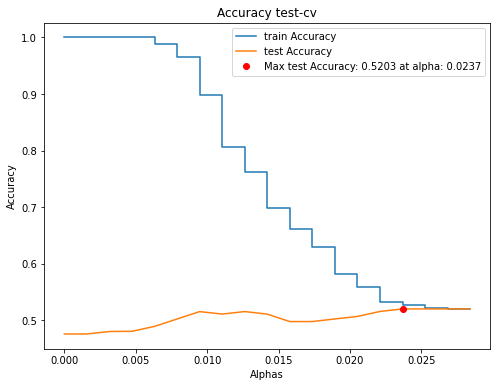

Accuracy Train: 0.5198
Accuracy Test: 0.5000


In [ ]:
ccp_alphas_cv = np.linspace(0,0.03,20)
X_train, X_test, y_train, y_test = data_set_1
optimal_regr_tree, ccp_alphas_optimal = display_regr_tree_pruning_cv_result(ccp_alphas_cv, X_train, y_train, rdn_forest=True)
print('Accuracy Train: {:.4f}'.format(optimal_regr_tree.score(X_train, y_train)))
print('Accuracy Test: {:.4f}'.format(optimal_regr_tree.score(X_test, y_test)))

In [ ]:
ada_model = AdaBoostClassifier(base_estimator=optimal_regr_tree, n_estimators=200, learning_rate=0.1, random_state=42)
ada_model.fit(X_train, y_train)
print('Accuracy Train: {:.4f}'.format(ada_model.score(X_train, y_train)))
print('Accuracy Test: {:.4f}'.format(ada_model.score(X_test, y_test)))

Accuracy Train: 0.6476
Accuracy Test: 0.4737


In [ ]:
xgboost = XGBClassifier(base_estimator=optimal_regr_tree, n_estimators=150, learning_rate=0.1, random_state=42)
xgboost.fit(X_train, y_train)
print('R2 Train: {:.4f}'.format(xgboost.score(X_train, y_train)))
print('R2 Test: {:.4f}'.format(xgboost.score(X_test, y_test)))

R2 Train: 0.9427
R2 Test: 0.4211


- Random Forest, AdaBoost, XGBoost dường như không cải thiện được accuracy.
- Mặc dù dataset nhỏ, nhưng thử sử dụng model Deep learning đơn giản xem ra sao.

In [ ]:
X_train, X_test, y_train, y_test = data_set_1

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Model
n = 50
input = Input(shape=(X_train.shape[1],))
x = Dense(n)(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(n)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(n)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(n)(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=[input], outputs=[output])

model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint_cb], verbose=2)
model.evaluate(X_test, y_test)

Epoch 1/100
8/8 - 2s - loss: 1.2666 - accuracy: 0.4802 - val_loss: 1.1835 - val_accuracy: 0.5000
Epoch 2/100
8/8 - 0s - loss: 0.9641 - accuracy: 0.5463 - val_loss: 1.3136 - val_accuracy: 0.3553
Epoch 3/100
8/8 - 0s - loss: 0.9259 - accuracy: 0.5639 - val_loss: 1.0869 - val_accuracy: 0.4868
Epoch 4/100
8/8 - 0s - loss: 0.8880 - accuracy: 0.5639 - val_loss: 1.0936 - val_accuracy: 0.5132
Epoch 5/100
8/8 - 0s - loss: 0.8877 - accuracy: 0.5551 - val_loss: 1.1168 - val_accuracy: 0.5132
Epoch 6/100
8/8 - 0s - loss: 0.7504 - accuracy: 0.6608 - val_loss: 1.0679 - val_accuracy: 0.4342
Epoch 7/100
8/8 - 0s - loss: 0.7897 - accuracy: 0.6300 - val_loss: 1.0586 - val_accuracy: 0.4868
Epoch 8/100
8/8 - 0s - loss: 0.7024 - accuracy: 0.6740 - val_loss: 1.0744 - val_accuracy: 0.4868
Epoch 9/100
8/8 - 0s - loss: 0.7336 - accuracy: 0.6564 - val_loss: 1.1003 - val_accuracy: 0.5000
Epoch 10/100
8/8 - 0s - loss: 0.6658 - accuracy: 0.7225 - val_loss: 1.1228 - val_accuracy: 0.4474
Epoch 11/100
8/8 - 0s - loss:

[2.2591094970703125, 0.3684210479259491]

Với deep learning, model vẫn không hiệu quả

**Kết luận**:
- Sau khi thực hiện cả Regression và Classification trên data set cholesterol, không có model nào thực sự có thể dùng được để áp dụng vào thực tế.
- Vấn đề nằm ở chính data vì tương quan thật sự giữa input và output rất thấp, nên không thể sử dụng được để dự đoán Cholesterol.
